Скачивание всех зависимостей проекта

In [7]:
!pip install -r requirements.txt

Авторизация в wandb 

In [1]:
!wandb login | cat wandb_secret.txt

"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import keras 

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pymorphy2
import Levenshtein
import gensim.downloader
import wandb
import json

import warnings
warnings.filterwarnings("ignore")

c:\Users\pasin\DS\Доп\generation_of_paronyms\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Чтение данных

In [4]:
# конфигурация
with open('config.json', 'r') as file:
    config = json.load(file)

cat = config['catboost']
nn = config['nn']
path = config['data_path']

In [5]:
# датафрейм 
data = pd.read_csv(path, index_col=0)

Препроцессинг

In [6]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [9]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [10]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
1,сравнимый,неорганичный,0,-0.043983,-0.009047,-0.063538,0.147805,-0.161587,0.027221,0.032012,...,-0.034892,0.018441,0.069707,-0.001893,-0.062972,0.145138,0.147791,-0.062155,0.080968,7
2,чубастый,завоевательный,0,-0.051917,0.044872,0.014789,0.002823,-0.002203,0.050730,0.031053,...,0.046212,-0.020866,-0.080959,-0.085725,-0.003354,0.015747,0.017519,-0.042495,0.167213,11
3,обидчивый,азарт,0,0.023674,0.052748,-0.034327,-0.031669,-0.014316,0.073295,-0.061295,...,-0.039973,-0.012380,-0.012538,-0.200660,-0.089638,-0.017675,0.042906,-0.012042,-0.019632,9
4,личностный,личный,1,-0.045874,-0.051794,-0.059747,0.019997,-0.075421,-0.042737,-0.057829,...,0.022120,-0.057636,0.027975,-0.042808,-0.101067,0.031723,0.043072,-0.031811,0.032527,4


PCA сокращение размерности эмбедингов

In [11]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [12]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = 150

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}))

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_141,emb_2_142,emb_2_143,emb_2_144,emb_2_145,emb_2_146,emb_2_147,emb_2_148,emb_2_149,lev_dist
0,0.092990,0.064130,-0.009231,-0.117480,0.119546,-0.012407,0.001258,0.036711,0.056221,0.036375,...,-0.002481,-0.068694,-0.000687,-0.055923,0.020807,-0.049057,0.030389,0.035299,-0.113363,2
1,-0.073190,0.121473,0.159301,-0.092435,-0.064992,0.211331,0.043879,-0.079573,0.139453,-0.007543,...,-0.060633,0.012755,0.004885,-0.003676,-0.004572,0.059856,0.014552,0.010245,0.020397,7
2,0.404789,-0.048654,-0.008222,-0.030357,-0.002150,0.115744,-0.036572,0.107039,-0.181169,-0.009343,...,0.040152,-0.087353,-0.009268,0.067529,0.001737,-0.027462,0.003259,-0.021811,-0.040529,11
3,0.093875,-0.295198,-0.023503,0.178027,-0.329818,-0.137435,0.063093,-0.033617,-0.093357,-0.018617,...,-0.045400,-0.043803,0.037817,-0.147127,0.023568,-0.015000,-0.019410,-0.043357,0.051759,9
4,-0.438857,-0.025888,0.076917,-0.048276,-0.095657,-0.114352,-0.050334,-0.016785,0.099318,-0.067110,...,0.070650,0.022765,0.013599,-0.039222,0.067906,-0.010029,0.030578,0.009976,0.023142,4


In [13]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.8158165856483836

In [14]:
X["lev_dist_2"] = X.lev_dist**2

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Катбуст

In [16]:
if config["logging"]:
    wandb.init(project="paronyms", tags=["cat", "with dist 2"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: kialimkhanov (paronyms). Use `wandb login --relogin` to force relogin


In [17]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0)
    }

    model = CatBoostClassifier(verbose=0, **params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
cat_model = CatBoostClassifier(verbose=0, **best_params)
cat_model.fit(X_train, y_train)
best_predictions = cat_model.predict(X_test)
best_mae = mean_absolute_error(y_test, best_predictions)
predictions = cat_model.predict_proba(X_test)

print('Best Parameters:', best_params)
print('Best MAE:', best_mae)

[I 2024-03-31 22:05:07,287] A new study created in memory with name: no-name-0be82f6f-034e-4eb5-89d3-01be97b574dd
[I 2024-03-31 22:07:01,811] Trial 0 finished with value: 0.057065217391304345 and parameters: {'learning_rate': 0.035225123851686156, 'depth': 8, 'l2_leaf_reg': 1.8095730691731395, 'bagging_temperature': 0.17311584409169586}. Best is trial 0 with value: 0.057065217391304345.
[I 2024-03-31 22:08:06,990] Trial 1 finished with value: 0.0625 and parameters: {'learning_rate': 0.019379609591701465, 'depth': 7, 'l2_leaf_reg': 6.185710948119225, 'bagging_temperature': 0.03742752034782254}. Best is trial 0 with value: 0.057065217391304345.
[I 2024-03-31 22:08:21,409] Trial 2 finished with value: 0.051630434782608696 and parameters: {'learning_rate': 0.02598291309701293, 'depth': 4, 'l2_leaf_reg': 1.2559021545789457, 'bagging_temperature': 0.11507474362392638}. Best is trial 2 with value: 0.051630434782608696.
[I 2024-03-31 22:09:28,067] Trial 3 finished with value: 0.057065217391304

Best Parameters: {'learning_rate': 0.04722337081770005, 'depth': 4, 'l2_leaf_reg': 0.37242736537446613, 'bagging_temperature': 0.32791405998389356}
Best MAE: 0.04891304347826087


In [18]:
treshold = cat["treshold"]

mae = mean_absolute_error(y_test, predictions[:, 1])
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions[:, 1]])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": best_params})
    wandb.finish()

MAE: 0.06502903277520704  Accuracy: 0.9510869565217391


Accuracy,▁
MAE,▁
Accuracy,0.95109
MAE,0.06503


In [19]:
# слова в которых модель ошиблась
errors = y_test != [1 if prob > treshold else 0 for prob in predictions[:, 1]]
words_with_errors = data.iloc[errors[errors==True].index]
print(words_with_errors)

               word1               word2  label   emb_1_0   emb_1_1   emb_1_2  \
1347       этический             близкий      0 -0.103671  0.035200  0.036793   
923   притягательный       покупательный      0  0.029180 -0.016150 -0.003119   
1185    производство  производительность      1  0.003287 -0.040107 -0.063265   
111       городничий             горячий      0 -0.016273 -0.039705  0.004870   
1173         звучный            широтный      0  0.028042  0.081736 -0.040153   
1313         пометка             военный      0  0.138845  0.016579  0.024741   
1466      заботливый             рабочий      0  0.048409 -0.072244  0.111143   
1735       заводской           складской      0  0.028808  0.030437  0.018462   
1317         главный            ответный      0  0.141978 -0.006733  0.123000   
1331       старинный           жизненный      0  0.065109 -0.019124  0.032137   
450           формат            дипломат      0  0.051160  0.014378  0.013035   
997          именной        

Видно, что модель часто делает ошибки первого рода (ложноположительные предсказания). Хотя по этим словам легко определить, что они не паронимы, так как у них большое расстояние левинштейна. Возможно стоит попробовать добавить новые признаки по lev_dist, например квадрат этой величины

In [20]:
# get feature importance
feature_importances = cat_model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 4.21563168709475
emb_1_1: 0.9312086147875122
emb_1_2: 0.18968907239278512
emb_1_3: 0.2371208905046292
emb_1_4: 0.09794512214652944
emb_1_5: 0.3738382900007044
emb_1_6: 0.3078067687988848
emb_1_7: 0.24777239563223213
emb_1_8: 0.25334330524018517
emb_1_9: 0.04732290334633345
emb_1_10: 0.45622974001602473
emb_1_11: 0.1715159823377406
emb_1_12: 0.06169351853298266
emb_1_13: 1.7753845420620782
emb_1_14: 0.0747864367487962
emb_1_15: 0.0
emb_1_16: 0.2498065340539056
emb_1_17: 0.6683685383294558
emb_1_18: 0.12088064567770611
emb_1_19: 0.18520404710805577
emb_1_20: 0.0474407852987644
emb_1_21: 0.1157834796009567
emb_1_22: 0.03774194122925543
emb_1_23: 0.021039087579639123
emb_1_24: 0.2506367646706214
emb_1_25: 0.13547054033846453
emb_1_26: 0.06774486771458141
emb_1_27: 0.08351735559730653
emb_1_28: 0.0031909835902744223
emb_1_29: 0.12323466903120939
emb_1_30: 0.4511010904400905
emb_1_31: 0.06397545867606373
emb_1_32: 0.1588592273433239
emb_1_33: 0.07488989861066683
emb_1_34: 0.08032522

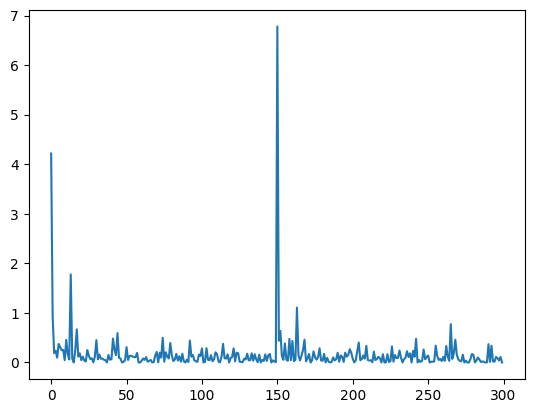

In [22]:
# plotting feature importance of embeddings
plt.plot(cat_model.feature_importances_[:-2])

Нейросеть

In [23]:
# Логирование
if config["logging"]:
    wandb.init(project="paronyms", tags=["nn", "with dist 2"])
    wandb.log(nn)

In [24]:
nn_model = tf.keras.Sequential()

optimizer = keras.optimizers.Adam(learning_rate=nn["lr"])
layers = nn["layers"]
activations = nn["activations"]

for i in range(len(layers)):
    if i == 0:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i], input_shape=(X_train.shape[1],)))
    else:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i]))

nn_model.compile(optimizer=optimizer, loss='mean_absolute_error')

history = nn_model.fit(X_train, y_train, epochs=nn["epochs"], batch_size=nn["batch_size"], verbose=0)

predictions = nn_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


MAE: 0.05688547324249235  Accuracy: 0.9429347826086957


Accuracy,▁
MAE,▁
batch_size,▁
epochs,▁
lr,▁
treshold,▁
Accuracy,0.94293
MAE,0.05689
batch_size,16
epochs,100
lr,0.0005


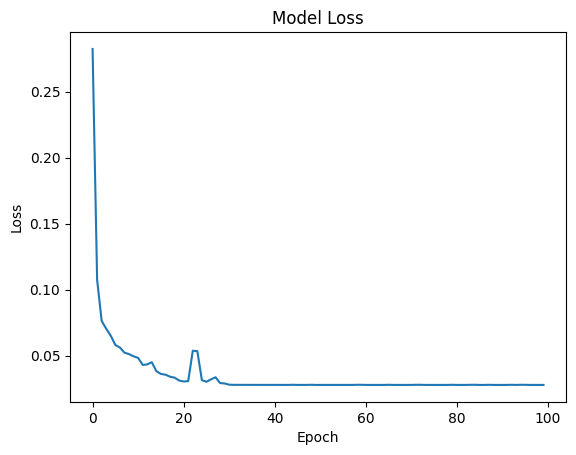

In [25]:
treshold = nn["treshold"]

mae = mean_absolute_error(y_test, predictions)
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc})
    wandb.finish()

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Тестирование

In [ ]:
# function for testing new words
def test(word1, word2, model):

    # getting embs and lev dist 
    emb1, emb2 = get_embedding(word1), get_embedding(word2)
    pca_emb1 = reduce_dimension(pca, emb1.reshape(1, -1))
    pca_emb2 = reduce_dimension(pca, emb2.reshape(1, -1))
    lev_dist = Levenshtein.distance(word1, word2)

    # creating dataframe
    row = pca_emb1.tolist()[0] + pca_emb2.tolist()[0] + [lev_dist]
    X_new = pd.DataFrame([row], columns=X.columns)
    
    # predictions 
    if model == "cat":
        prediction = cat_model.predict_proba(X_new)
        res = np.argmax(prediction[0])
        proba = max(prediction[0])

    if model == "nn":
        prediction = nn_model.predict(X_new)
        if prediction[0][0] < 0.5:
            res = 0
            proba = 1 - (prediction[0][0] if prediction[0][0] > 0 else 0)
        else:
            res = 1
            proba = (prediction[0][0] if prediction[0][0] < 1 else 1)

    # result
    print(f"Слова {word1} и {word2} {'не '*(not res)}являются паронимами с вероятностью {proba}")

In [ ]:
# не паронимы
word1 = "приветливый"
word2 = "страна" 

# паронимы
word1 = "целый"
word2 = "цельный" 

# модель 
model = "cat" # nn - keras nn, cat - catboostclassifier

# тестирование
test(word1, word2, model)

Мусорка

In [97]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [96]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [85]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None
